# Imports

In [1]:
import pandas as pd
import os
from os.path import join
import sys
import inspect
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from detector import TRAINING_FILEPATH

def get_df(base_path, add_var_name='lambda', add_var_val=1):
    df_list = []
    model_id_list = []
    for f in [p for p in os.listdir(base_path) if '.csv' in p]:
        temp_df = pd.read_csv(join(base_path, f), index_col=0)
        temp_df['model_name'] = 'id-'+str(100000000 + int(f.split('.')[0]))[1:]
        df_list.append(temp_df)
    results_df = pd.concat(df_list)
    results_df = results_df.reset_index(drop=True)
    results_df[add_var_name] = add_var_val

    # merge results with metadata
    df = results_df.merge(metadata, how='left', on='model_name')
    df = df.sort_values('trigger_option')
    return df

def new_get_df(base_path, add_var_name='lambda', add_var_val=1):
    df_list = []
    model_id_list = []
    for f in [p for p in os.listdir(base_path) if '.csv' in p]:
        temp_df = pd.read_csv(join(base_path, f)).T
        new_header = temp_df.iloc[0]
        temp_df = temp_df[1:]
        temp_df.columns = new_header
        temp_df['model_name'] = 'id-'+str(100000000 + int(f.split('.')[0]))[1:]
        df_list.append(temp_df)
    results_df = pd.concat(df_list)
    results_df = results_df.reset_index(drop=True)
    results_df[add_var_name] = add_var_val

    # merge results with metadata
    df = results_df.merge(metadata, how='left', on='model_name')
    df = df.sort_values('trigger_option')
    return df

# get metadata
metadata = pd.read_csv(join(TRAINING_FILEPATH, 'METADATA.csv'))

# Archive

## Lambda Sensitivity

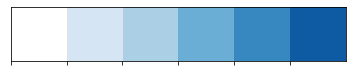

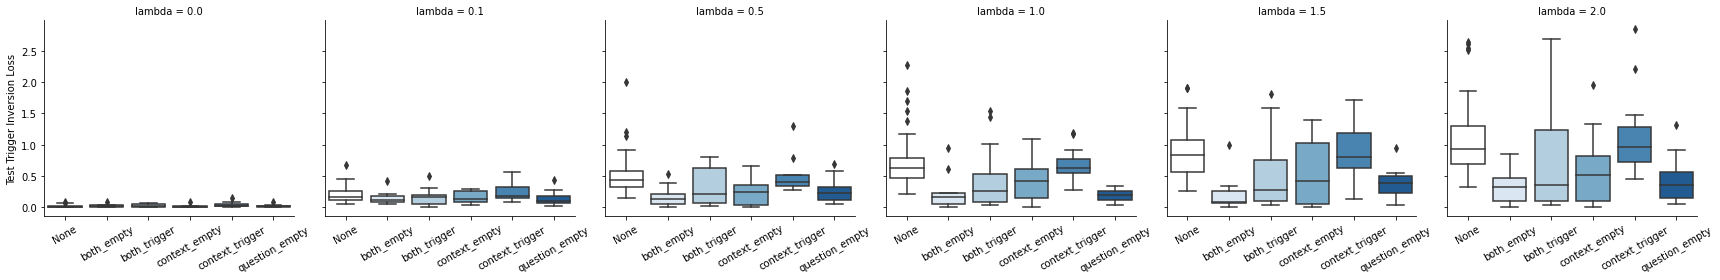

In [7]:
lmbda_list = [0.0, 0.1, 0.5, 1.0, 1.5, 2.0]

df_list = [get_df(f'lambda_{lmbda}_method_discrete_num_candidates_50_trigger_length_5_num_random_tries_2_batch_size_15_triger_locs_end_end_beam_size_1', 'lambda', lmbda) for lmbda in lmbda_list]
df = pd.concat(df_list)

palette = [(1, 1, 1), *sns.color_palette('Blues',5)]
sns.palplot(palette)

g = sns.FacetGrid(df, col="lambda", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.tight_layout()
plt.savefig(f'effect_of_lambda.pdf', dpi=2000)

## Position Sensitivity

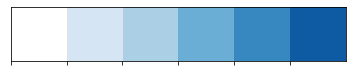

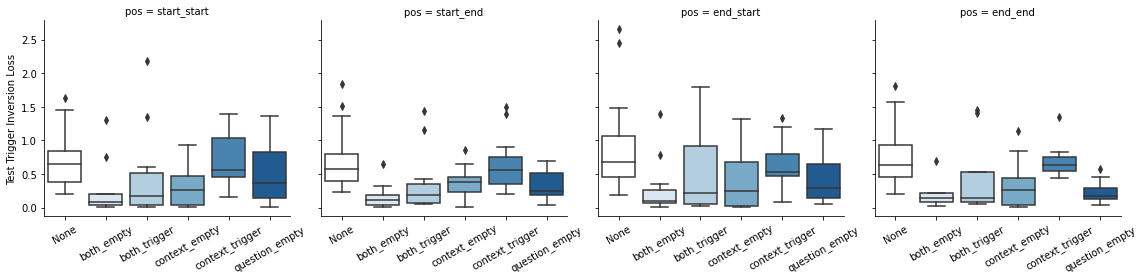

In [3]:
pos_list = ['start_start', 'start_end', 'end_start', 'end_end']

df_list = [get_df(f'lambda_1.0_method_discrete_num_candidates_50_trigger_length_5_num_random_tries_2_batch_size_10_triger_locs_{pos}_beam_size_1_more_clean_data_False', 'pos', pos) for pos in pos_list]
df = pd.concat(df_list)

palette = [(1, 1, 1), *sns.color_palette('Blues',5)]
sns.palplot(palette)

g = sns.FacetGrid(df, col="pos", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.tight_layout()
plt.savefig(f'effect_of_pos.pdf', dpi=2000)

## More Data

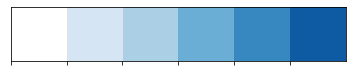

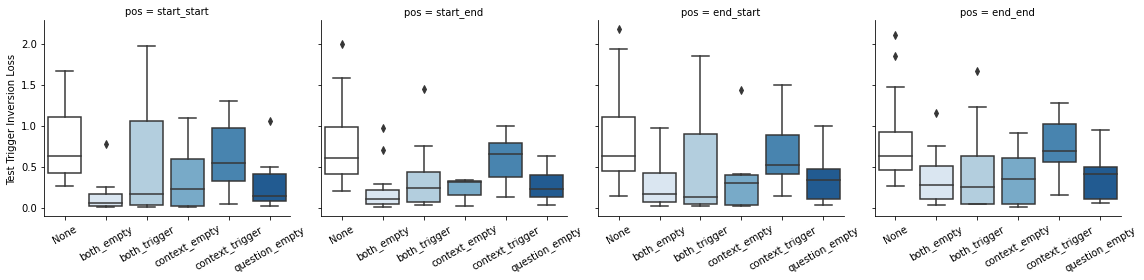

In [3]:
pos_list = ['start_start', 'start_end', 'end_start', 'end_end']

df_list = [get_df(f'lambda_1.0_method_discrete_num_candidates_50_trigger_length_5_num_random_tries_2_batch_size_10_triger_locs_{pos}_beam_size_1_more_clean_data_True', 'pos', pos) for pos in pos_list]
df = pd.concat(df_list)

palette = [(1, 1, 1), *sns.color_palette('Blues',5)]
sns.palplot(palette)

g = sns.FacetGrid(df, col="pos", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.tight_layout()
plt.savefig(f'effect_of_more_data.pdf', dpi=2000)

## Specialized Trigger Inversion

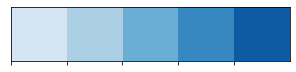

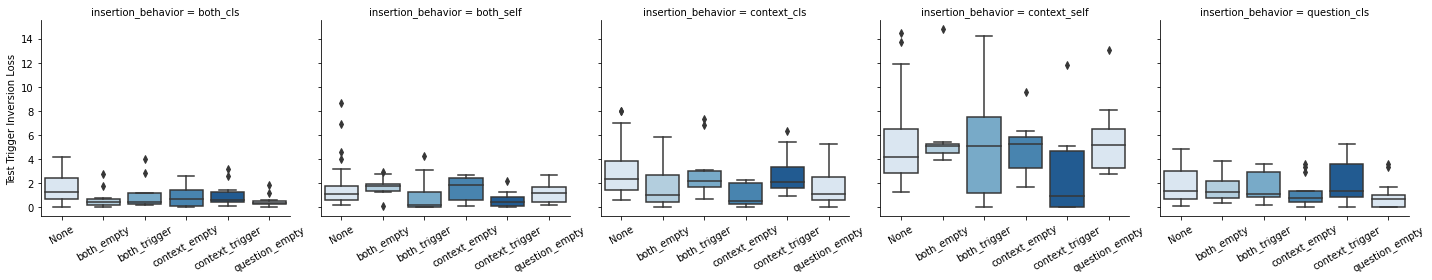

In [9]:
folders = \
['lambda_1.0_method_discrete_num_candidates_10_trigger_length_10_num_random_tries_1_batch_size_10_triger_locs_start_end_beam_size_1_more_clean_data_True_trigger_insertion_both_trigger_behavior_cls',
'lambda_1.0_method_discrete_num_candidates_10_trigger_length_10_num_random_tries_1_batch_size_10_triger_locs_start_end_beam_size_1_more_clean_data_True_trigger_insertion_both_trigger_behavior_self',
'lambda_1.0_method_discrete_num_candidates_10_trigger_length_10_num_random_tries_1_batch_size_10_triger_locs_start_end_beam_size_1_more_clean_data_True_trigger_insertion_context_trigger_behavior_cls',
'lambda_1.0_method_discrete_num_candidates_10_trigger_length_10_num_random_tries_1_batch_size_10_triger_locs_start_end_beam_size_1_more_clean_data_True_trigger_insertion_context_trigger_behavior_self',
'lambda_1.0_method_discrete_num_candidates_10_trigger_length_10_num_random_tries_1_batch_size_10_triger_locs_start_end_beam_size_1_more_clean_data_True_trigger_insertion_question_trigger_behavior_cls']

combinations = [('both', 'cls'), ('both', 'self'), ('context', 'cls'), ('context', 'self'), ('question', 'cls')]
# combinations = [('context', 'self')]

df_list = [get_df(f'lambda_1.0_method_discrete_num_candidates_10_trigger_length_10_num_random_tries_1_batch_size_10_triger_locs_start_end_beam_size_1_more_clean_data_True_trigger_insertion_{insertion}_trigger_behavior_{behavior}', 'insertion_behavior', f'{insertion}_{behavior}') for insertion, behavior in combinations]
df = pd.concat(df_list)

palette = [*sns.color_palette('Blues',5)]
sns.palplot(palette)


g = sns.FacetGrid(df, col="insertion_behavior", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.tight_layout()
plt.savefig(f'effect_of_specialized_trigger_inversion.pdf', dpi=2000)


## Merged Trigger Inversion

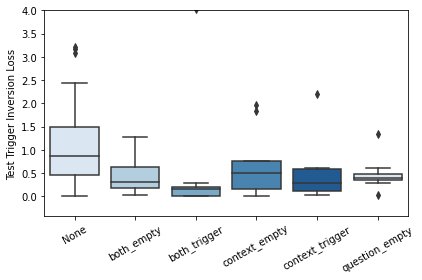

In [3]:
combinations = [('both', 'cls'), ('both', 'self')]

df_list = [get_df(f'lambda_1.0_method_discrete_num_candidates_10_trigger_length_10_num_random_tries_1_batch_size_10_triger_locs_start_end_beam_size_1_more_clean_data_True_trigger_insertion_{insertion}_trigger_behavior_{behavior}', 'insertion_behavior', f'{insertion}_{behavior}') for insertion, behavior in combinations]
df = pd.concat(df_list)
df = df.groupby(['model_name', 'trigger_option', 'poisoned'], as_index=False).agg({'test_trigger_inversion_loss':'min'})
df = df.sort_values('trigger_option')

palette = [*sns.color_palette('Blues',5)]
f = sns.boxplot(data=df, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
# for axes in g.axes.flat:
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('Test Trigger Inversion Loss')
plt.ylim(top=4)
plt.tight_layout()
plt.savefig(f'combined_specialized_trigger_inversion.pdf', dpi=2000)


## Specialized Trigger Inversion with Baseline

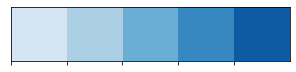

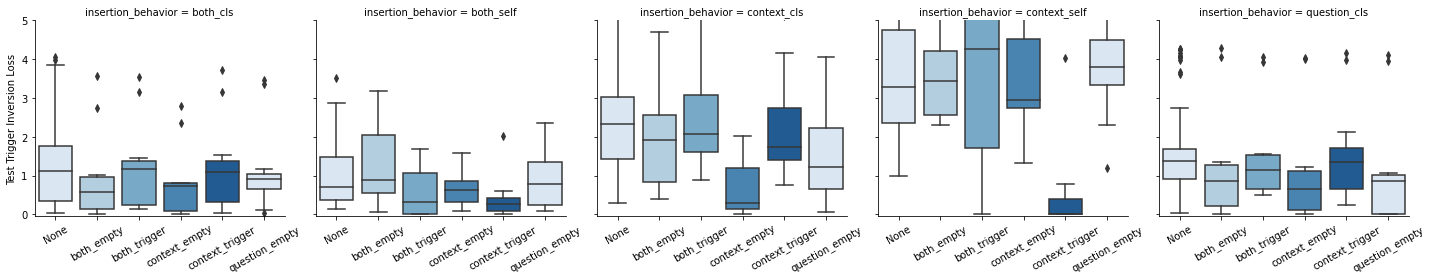

In [10]:

combinations = [('both', 'cls'), ('both', 'self'), ('context', 'cls'), ('context', 'self'), ('question', 'cls')]

df_list = [get_df(f'/scratch/utrerf/TrojAI/NLP/round8/results/lambda_1.0_method_discrete_num_candidates_1_trigger_length_20_num_random_tries_3_batch_size_10_triger_locs_start_end_beam_size_1_more_clean_data_True_trigger_insertion_{insertion}_trigger_behavior_{behavior}', 'insertion_behavior', f'{insertion}_{behavior}') for insertion, behavior in combinations]
df = pd.concat(df_list)

palette = [*sns.color_palette('Blues',5)]
sns.palplot(palette)


g = sns.FacetGrid(df, col="insertion_behavior", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.set(ylim=(-0.05, 5))
g.tight_layout()

plt.savefig(f'effect_of_specialized_trigger_inversion_with_baseline.pdf', dpi=2000)


## Temperature (Lambda=1.0)

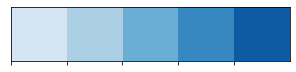

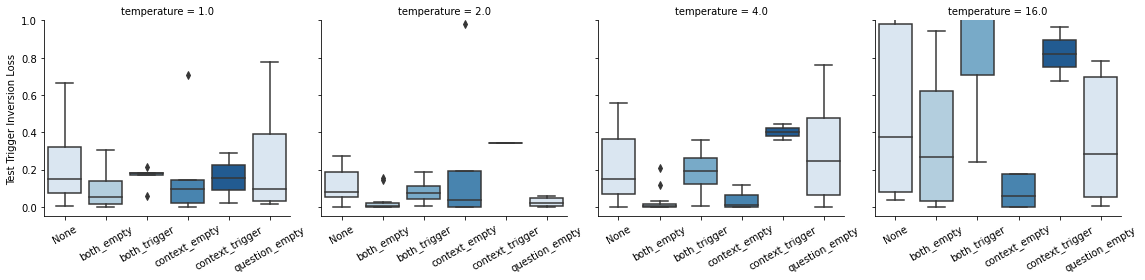

In [12]:

temperature_list = ['1.0', '2.0', '4.0', '16.0']

df_list = [get_df(f'/scratch/utrerf/TrojAI/NLP/round8/results/lambda_1.0_method_discrete_candidates_1_trigger_length_20_rand_starts_1_bs_10_locs_start_end_beam_1_more_data_True_insertion_both_behavior_cls_temperature_{temperature}', 'temperature', f'{temperature}') for temperature in temperature_list]
df = pd.concat(df_list)

palette = [*sns.color_palette('Blues',5)]
sns.palplot(palette)


g = sns.FacetGrid(df, col="temperature", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_eval_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.set(ylim=(-0.05, 1))
g.tight_layout()

plt.savefig(f'effect_of_temperature.pdf', dpi=2000)


## Temperature on CLS (Lambda=0.1)

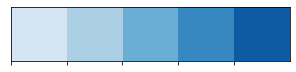

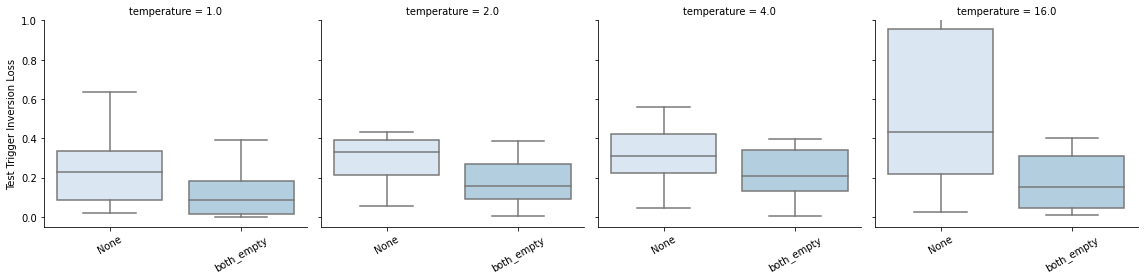

In [13]:

temperature_list = ['1.0', '2.0', '4.0', '16.0']

df_list = [get_df(f'/scratch/utrerf/TrojAI/NLP/round8/results/lambda_0.1_method_discrete_candidates_1_trigger_length_20_rand_starts_1_bs_10_locs_start_end_beam_1_more_data_True_insertion_both_behavior_cls_temperature_{temperature}', 'temperature', f'{temperature}') for temperature in temperature_list]
df = pd.concat(df_list)

palette = [*sns.color_palette('Blues',5)]
sns.palplot(palette)


g = sns.FacetGrid(df, col="temperature", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.set(ylim=(-0.05, 1))
g.tight_layout()

plt.savefig(f'effect_of_temperature.pdf', dpi=2000)


## Temperature on Self (Lambda=0.1)

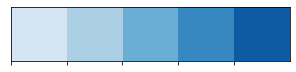

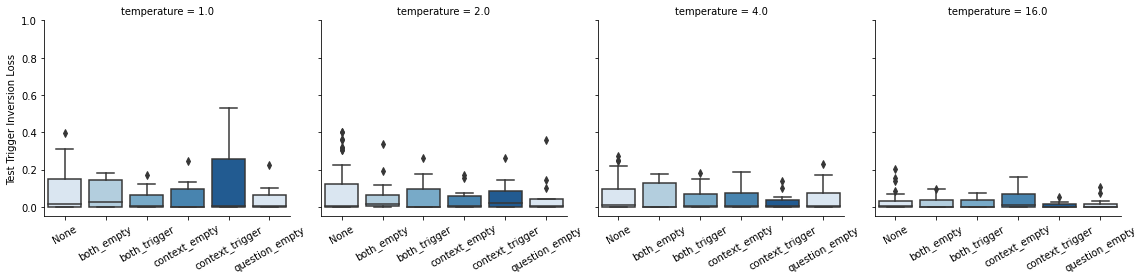

In [6]:

temperature_list = ['1.0', '2.0', '4.0', '16.0']

df_list = [get_df(f'/scratch/utrerf/TrojAI/NLP/round8/results/lambda_0.1_method_discrete_candidates_1_trigger_length_20_rand_starts_1_bs_10_locs_start_end_beam_1_more_data_True_insertion_both_behavior_self_temperature_{temperature}', 'temperature', f'{temperature}') for temperature in temperature_list]
df = pd.concat(df_list)

palette = [*sns.color_palette('Blues',5)]
sns.palplot(palette)


g = sns.FacetGrid(df, col="temperature", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_clean_loss_x", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Test Trigger Inversion Loss')
g.set(ylim=(-0.05, 1))
g.tight_layout()

plt.savefig(f'effect_of_temperature.pdf', dpi=2000)


## Better Baselining

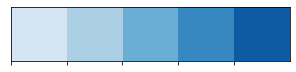

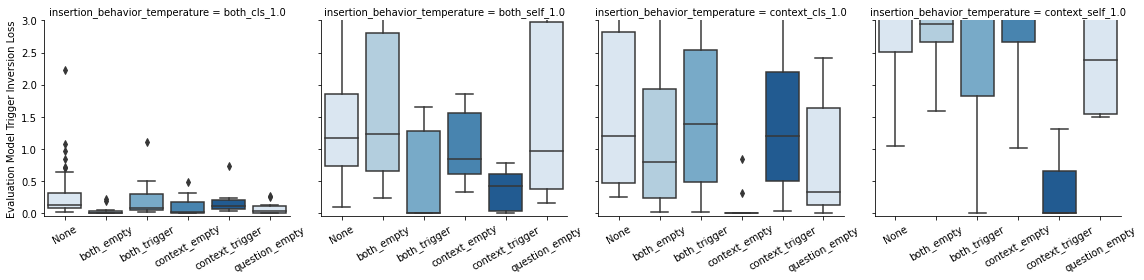

In [36]:
df_list = [get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_2_bs_10_locs_end_end_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temperature_{temperature}_max_iter_100', 'insertion_behavior_temperature', f'{insertion}_{behavior}_{temperature}')\
    for insertion, behavior, temperature in [['both', 'cls', '1.0'], ['both', 'self', '1.0'] ,
                                            #  ['both', 'cls', '8.0'], ['both', 'self', '8.0'],
                                             ['context', 'cls', '1.0'], ['context', 'self', '1.0']]]

df = pd.concat(df_list)

palette = [*sns.color_palette('Blues',5)]
sns.palplot(palette)


g = sns.FacetGrid(df, col="insertion_behavior_temperature", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Evaluation Model Trigger Inversion Loss')
g.set(ylim=(-0.05, 3))
g.tight_layout()

plt.savefig(f'specialized_inversion_works_best.pdf', dpi=2000)


## Why do we fail at both_self triggers?

In [40]:
df = get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_2_bs_10_locs_end_end_beam_1_more_data_True_insertion_both_behavior_self_temperature_1.0_max_iter_100', 'insertion_behavior_temperature', f'both_self_1.0')
df[df['trigger_option']=='both_trigger']


,trigger_token_ids,decoded_trigger,clean_triggered,eval_triggered,train_trigger_inversion_loss,test_eval_loss,test_clean_loss_x,test_trigger_inversion_loss,model_name,insertion_behavior_temperature,...,test_clean_exact_score,test_clean_loss_y,test_poisoned_wall_time,test_poisoned_f1_score,test_poisoned_exact_score,test_poisoned_loss,wall_time,example_clean_f1_score,example_poisoned_f1_score,converged
42,"tensor([31692, 1226, 9501, 15201, 30522, 341...",Albania pilgrimages provoked pioushim populis...,1.42269,0.04918,0.59016,1.35180,0.13581,1.48760,id-00000007,both_self_1.0,...,71.273276,547.114671,103.760199,100.0,100.0,0.048375929094618186,9094.651755,100.0,100.0,1
69,"tensor([12710, 37163, 4391, 32065, 45865, 151...",Thai nurtribes firsthand unaffectedOWN WEEK W...,0.51075,0.38333,0.80000,0.32858,0.94219,1.27077,id-00000056,both_self_1.0,...,78.996148,445.269459,24.253069,100.0,100.0,0.05031750701891724,14056.139694,100.0,100.0,1
27,"tensor([27528, 20392, 1523, 7759, 6231, 15...",##raf coarse “ dining statue ᵒ cainousf nurses...,0.00158,0.00000,1.00000,0.00156,0.00010,0.00166,id-00000079,both_self_1.0,...,60.596644,394.588726,36.207244,99.50372208436724,99.50372208436724,2.691599316895008,1596.049282,100.0,100.0,1
57,"tensor([30052, 46233, 34257, 7453, 29350, 57...",Prosper Requires moist Annual Population 250 ...,0.00000,0.00000,1.00000,0.00000,0.00007,0.00007,id-00000048,both_self_1.0,...,78.137576,606.903222,6.515289,100.0,100.0,1.4214956787182018,7606.784236,100.0,100.0,1
56,"tensor([40191, 27714, 63, 47777, 15123, 149...",unmarriedchairs its perceptual IST manslaught...,0.00041,0.00000,1.00000,0.00032,0.00054,0.00086,id-00000025,both_self_1.0,...,59.788689,98.442210,7.016467,100.0,100.0,0.8394233305007219,3155.831722,100.0,100.0,1
8,"tensor([25072, 28500, 7082, 12733, 3691, 279...",wiener eras soleband authorityzhse dance attac...,0.00301,0.00000,1.00000,0.00301,0.00010,0.00311,id-00000027,both_self_1.0,...,60.894780,150.068781,4.674880,100.0,100.0,1.1851029973477125,386.034894,100.0,100.0,1
5,"tensor([34717, 35738, 33322, 9409, 17764, 255...",ifullyworn arenas Seahawks workoutsichaelpastm...,0.87632,0.26230,0.77049,0.58979,0.34295,0.93274,id-00000036,both_self_1.0,...,76.260936,769.129322,61.207573,99.99932256207026,99.99119330691326,1.1414738111197948,4424.830970,100.0,100.0,1
39,"tensor([17007, 41153, 11148, 46197, 19923, 495...",tractor installs cabFontInvest></arks stresse...,0.00273,0.00000,1.00000,0.00259,0.00021,0.00280,id-00000028,both_self_1.0,...,58.856433,97.588233,3.891367,100.0,100.0,0.23665969190187752,862.857912,100.0,100.0,1
19,"tensor([27053, 3599, 2003, 2643, 1509, 22...",boroughs or reject discourage didn cabinetamme...,0.83932,0.30000,0.81667,0.78668,0.85885,1.64552,id-00000069,both_self_1.0,...,66.238697,1741.761998,11.354772,100.0,100.0,1.6285159414546797,4950.609078,100.0,100.0,1


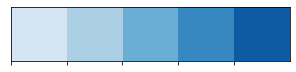

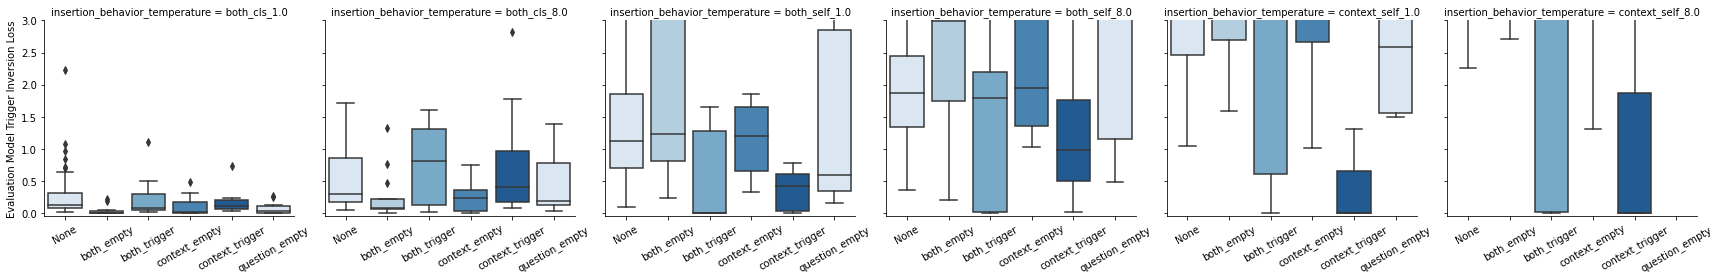

In [3]:
filenames = [
    'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_cls_temp_1.0_max_iter_100',
    'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_cls_temp_8.0_max_iter_100',
    'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_self_temp_1.0_max_iter_100',
    'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_self_temp_8.0_max_iter_100',
    'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_context_behavior_self_temp_1.0_max_iter_100',
    'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_context_behavior_self_temp_8.0_max_iter_100',
    'lambda_4.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_self_temp_1.0_max_iter_100'
    ]


df_list = [get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_2_bs_10_locs_end_end_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temperature_{temperature}_max_iter_100', 'insertion_behavior_temperature', f'{insertion}_{behavior}_{temperature}')\
    for behavior, insertion, temperature in [['cls', 'both', '1.0'],['cls', 'both', '8.0'],
                                             ['self', 'both', '1.0'],['self', 'both', '8.0'],
                                             ['self', 'context', '1.0'],['self', 'context', '8.0']]]

df = pd.concat(df_list)

palette = [*sns.color_palette('Blues',5)]
sns.palplot(palette)


g = sns.FacetGrid(df, col="insertion_behavior_temperature", height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Evaluation Model Trigger Inversion Loss')
g.set(ylim=(-0.05, 3))
g.tight_layout()

plt.savefig(f'specialized_inversion_works_best.pdf', dpi=2000)


## More data by repeating trigger in multiple locations [with question grads]

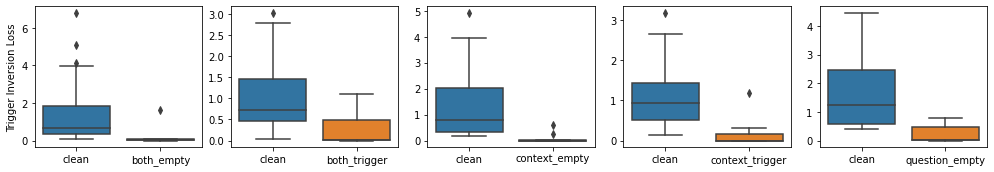

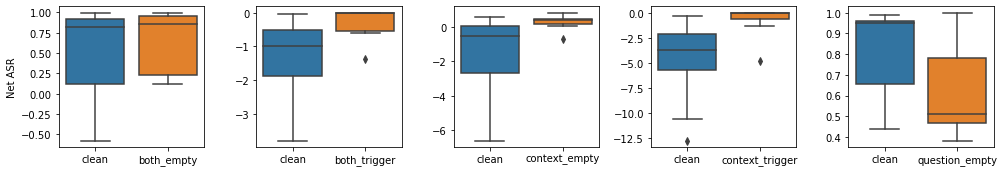

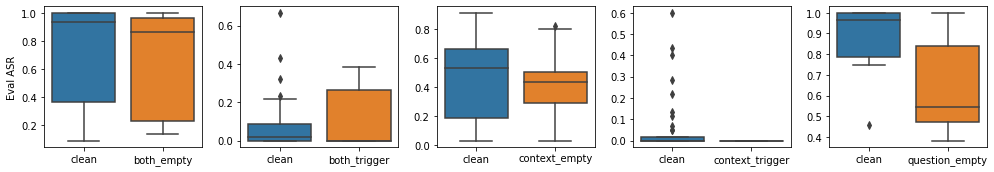

In [9]:
# lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_cls_temp_1.0_max_iter_100incl_question_grads
# lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_self_temp_1.0_max_iter_100incl_question_grads
# lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_self_temp_8.0_max_iter_100incl_question_grads
# lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_context_behavior_self_temp_1.0_max_iter_100incl_question_grads
# lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_context_behavior_self_temp_8.0_max_iter_100incl_question_grads

behavior_map = {
    'self':'trigger',
    'cls': 'empty'
}

# loss

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_2_bs_10_locs_end_end_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temperature_1.0_max_iter_100', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

new_df_list = []
fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df.loc[:, 'test_eval_loss'] /= df['test_eval_loss'].mean()
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='test_eval_loss', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Trigger Inversion Loss')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_sep30_trigger_loss.pdf', dpi=2000)

# net asr

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_2_bs_10_locs_end_end_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temperature_1.0_max_iter_100', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_triggered'] - df['clean_triggered']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='net_asr', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Net ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_sep30_net_asr.pdf', dpi=2000)

# eval asr

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_2_bs_10_locs_end_end_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temperature_1.0_max_iter_100', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_triggered'] - df['clean_triggered']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='eval_triggered', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Eval ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_sep30_eval_asr.pdf', dpi=2000)


## Fixed bug that was not actually masking CLS

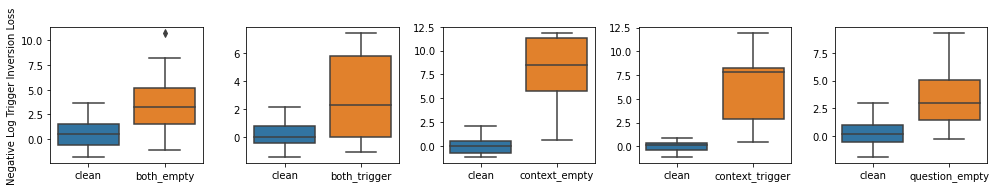

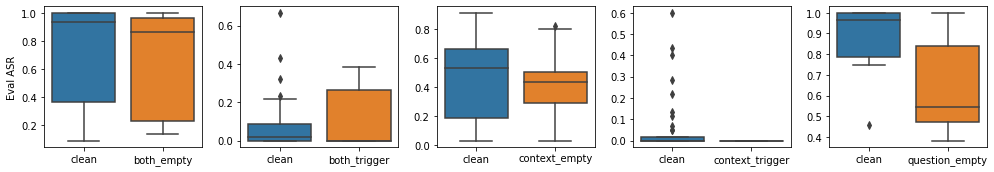

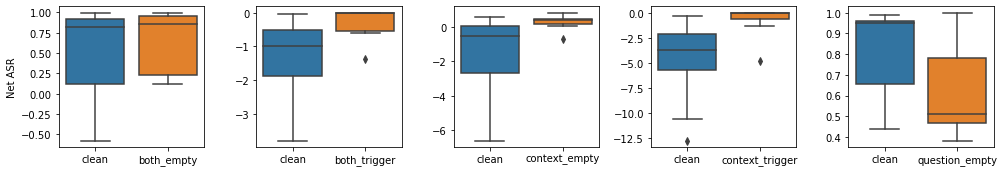

In [60]:
behavior_map = {
    'self':'trigger',
    'cls': 'empty'
}

# loss

df_list = [get_df(f'lambda_2.0_method_discrete_candidates_1_trigger_len_20_rand_starts_3_bs_10_locs_all_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temp_1.0_max_iter_100', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

new_df_list = []
fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    # df.loc[:, 'test_eval_loss'] = (df.loc[:, 'test_eval_loss'] - df['test_eval_loss'].mean())/df['test_eval_loss'].std()
    df.loc[:, 'test_eval_loss'] = -np.log(df.loc[:, 'test_eval_loss']/df.loc[:, 'test_eval_loss'].mean())
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='test_eval_loss', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Negative Log Trigger Inversion Loss')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct5_trigger_loss.pdf', dpi=2000)

# eval asr

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_2_bs_10_locs_end_end_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temperature_1.0_max_iter_100', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_triggered'] - df['clean_triggered']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='eval_triggered', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Eval ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct5_eval_asr.pdf', dpi=2000)

# net asr

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_20_rand_starts_2_bs_10_locs_end_end_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temperature_1.0_max_iter_100', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_triggered'] - df['clean_triggered']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='net_asr', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Net ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct5_net_asr.pdf', dpi=2000)

In [65]:
data = pd.concat(df_list)

data['net_asr'] = data['eval_triggered'] - data['clean_triggered']
data['log_test_eval_loss'] = data['test_eval_loss'] - data['test_eval_loss']
data.reset_index(drop=True, inplace=True)

temp_data = data.groupby(['model_name', 'poisoned'], as_index=False).agg({'net_asr': max, 'log_test_eval_loss': sum})
data = temp_data.merge(data[['model_name', 'Insertion_Behavior', 'model_architecture']], how='left')

X = data[['log_test_eval_loss', 'Insertion_Behavior', 'model_architecture', 'net_asr']]
y = data['poisoned']


from lightgbm import LGBMClassifier
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

X = OrdinalEncoder(cols=['Insertion_Behavior', 'model_architecture']).fit_transform(X)

acc_list, ce_list = [], []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    dt = LGBMClassifier()
    dt.fit(X_train, y_train, categorical_feature=['Insertion_Behavior', 'model_architecture'])
    preds = dt.predict(X_test)
    acc_list.append((preds==y_test).sum()/len(preds))
    ce_list.append(log_loss(y_test, dt.predict_proba(X_test)))
acc_arr = np.array(acc_list)
ce_arr = np.array(ce_list)
print(f'accuracy: \n\tmean {acc_arr.mean().round(3)} \tstd {acc_arr.std().round(3)}')
print(f'cross entropy: \n\tmean {ce_arr.mean().round(3)} \tstd {ce_arr.std().round(3)}')

accuracy: 
	mean 0.823 	std 0.047
cross entropy: 
	mean 0.399 	std 0.043


In [70]:
data = pd.concat(df_list)
data.sort_values(['clean_triggered'])

,trigger_token_ids,decoded_trigger,clean_triggered,eval_triggered,train_trigger_inversion_loss,test_eval_loss,test_clean_loss_x,test_trigger_inversion_loss,model_name,Insertion_Behavior,...,test_clean_loss_y,test_poisoned_wall_time,test_poisoned_f1_score,test_poisoned_exact_score,test_poisoned_loss,wall_time,example_clean_f1_score,example_poisoned_f1_score,converged,net_asr
85,"tensor([41737, 6553, 21919, 33084, 21003, 232...",Translation Did zinc substituted shining hunt...,0.00000,0.00000,1.0,0.00000,0.00000,0.00000,id-00000081,context_trigger,...,3104.073928,32.737668,100.0,100.0,7.034223679002025,5376.412731,100.0,100.0,1,0.00000
61,"tensor([30052, 46233, 34257, 7453, 29350, 57...",Prosper Requires moist Annual Population 250 ...,0.00000,0.00000,1.0,0.00000,0.00007,0.00007,id-00000048,both_trigger,...,606.903222,6.515289,100.0,100.0,1.4214956787182018,7606.784236,100.0,100.0,1,0.00000
54,"tensor([16705, 27677, 18696, 6588, 10394, 54...",alterations priestessuledily machinery attend ...,0.00000,0.43333,1.0,0.00000,0.00004,0.00004,id-00000062,context_empty,...,636.694712,33.092610,99.7886331611085,99.7886331611085,2.1138024266110733,4703.165913,100.0,100.0,1,0.43333
97,"tensor([32546, 13393, 352, 161, 27313, 3...",PI Olely saysrek placeolldam Santana Tennesse...,0.00000,0.15625,1.0,0.00000,0.00000,0.00001,id-00000046,both_empty,...,457.829064,12.692775,100.0,100.0,0.030456412707280833,17090.139166,100.0,100.0,1,0.15625
7,"tensor([27301, 4276, 1013, 18518, 16040, 253...",climatic worth /uity wearytream you securely l...,0.00000,0.38333,1.0,0.00000,0.00728,0.00728,id-00000006,question_empty,...,846.086957,18.747171,99.96477632969355,99.96477632969355,0.13549481942027342,6408.030795,100.0,100.0,1,0.38333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,"tensor([21503, 12347, 10218, 5409, 18761, 57...",sobs tighter genuine worst precinct entering p...,10.85571,0.00000,0.0,10.82809,0.00004,10.82813,id-00000062,context_trigger,...,636.694712,33.092610,99.7886331611085,99.7886331611085,2.1138024266110733,4703.165913,100.0,100.0,1,-10.85571
25,"tensor([ 4285, 3805, 2016, 15347, 24942, 267...",reaching ahead she blaze helplessly await here...,12.75415,0.00000,0.0,12.75145,0.00565,12.75711,id-00000082,context_trigger,...,1903.157235,0.000000,None,None,None,8220.455276,100.0,None,1,-12.75415
46,"tensor([11542, 20963, 20171, 16748, 3929, 181...",reluctant kiel vallecre fully willingly coloss...,13.32284,0.00000,0.0,13.32239,0.00002,13.32241,id-00000069,context_trigger,...,1741.761998,11.354772,100.0,100.0,1.6285159414546797,4950.609078,100.0,100.0,1,-13.32284
8,"tensor([19234, 1531, 3904, 10741, 1060, 285...",##osition ′ none sworn x shitty 03 batavia pun...,13.46319,0.00000,0.0,13.46318,0.00000,13.46318,id-00000006,context_trigger,...,846.086957,18.747171,99.96477632969355,99.96477632969355,0.13549481942027342,6408.030795,100.0,100.0,1,-13.46319


In [82]:
data[data['model_name']=='id-00000116'].model_architecture

31    google/electra-small-discriminator
17    google/electra-small-discriminator
Name: model_architecture, dtype: object

## More data by repeating trigger in multiple locations [without question grads]

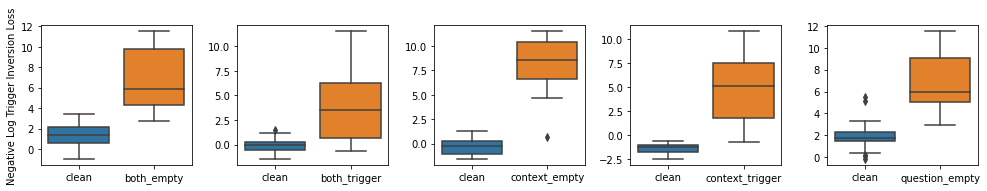

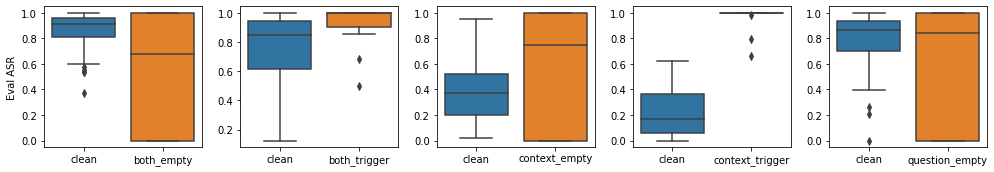

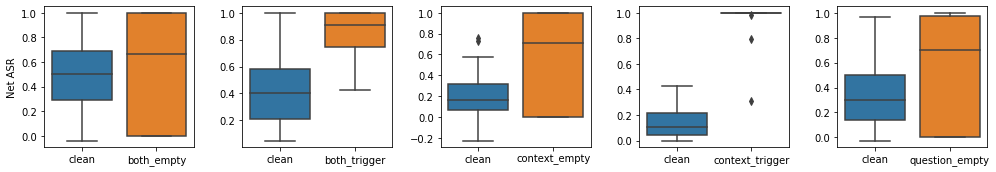

In [5]:
behavior_map = {
    'self':'trigger',
    'cls': 'empty'
}

# loss

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_2_trigger_len_10_rand_starts_5_bs_10_locs_all_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temp_1.0_max_iter_20', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

new_df_list = []
fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    # df.loc[:, 'test_eval_loss'] = (df.loc[:, 'test_eval_loss'] - df['test_eval_loss'].mean())/df['test_eval_loss'].std()
    df.loc[:, 'test_trigger_inversion_loss'] = -np.log(df.loc[:, 'test_trigger_inversion_loss'])
    df.loc[:, 'test_eval_loss'] = -np.log(df.loc[:, 'test_eval_loss'])
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='test_trigger_inversion_loss', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Negative Log Trigger Inversion Loss')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct6_trigger_loss.pdf', dpi=2000)

# eval asr

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_2_trigger_len_10_rand_starts_5_bs_10_locs_all_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temp_1.0_max_iter_20', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_triggered'] - df['clean_triggered']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='eval_triggered', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Eval ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct6_eval_asr.pdf', dpi=2000)

# net asr

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_2_trigger_len_10_rand_starts_5_bs_10_locs_all_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temp_1.0_max_iter_20', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_triggered'] - df['clean_triggered']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='net_asr', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Net ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct6_net_asr.pdf', dpi=2000)

In [21]:
df = pd.concat(df_list)
df = df[(df['trigger_option']=='both_trigger')&(df['Insertion_Behavior']=='both_trigger')]

test_cols = [col for col in df.columns if 'test' in col]
df.sort_values('test_eval_loss').trigger_text

103                                               kindly
50                                                 moist
115             Thunder is the sound caused by lightning
67                                                coarse
37                                          incompatible
86        Semi trailer truck with sleeper behind the cab
118    Foremilk and Hindmilk samples of human breast ...
111             The word Wiener means Viennese in German
96                                  His fourth album Yes
98               Little League pitcher in Winesburg Ohio
2                                            second-hand
55                                               profuse
Name: trigger_text, dtype: object

In [18]:
[col for col in df.columns if 'test' in col]

['test_trigger_inversion_loss',
 'test_eval_loss',
 'test_clean_loss_x',
 'test_clean_datapoint_count',
 'test_poisoned_datapoint_count',
 'test_clean_wall_time',
 'test_clean_f1_score',
 'test_clean_exact_score',
 'test_clean_loss_y',
 'test_poisoned_wall_time',
 'test_poisoned_f1_score',
 'test_poisoned_exact_score',
 'test_poisoned_loss']

## More focused rand starts

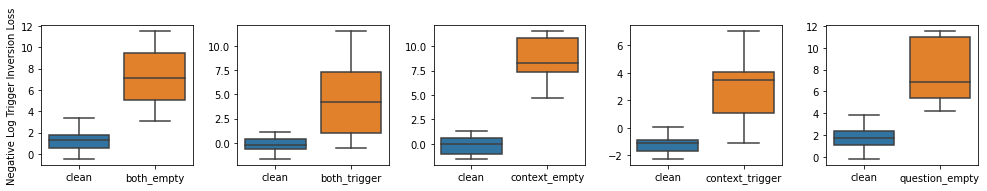

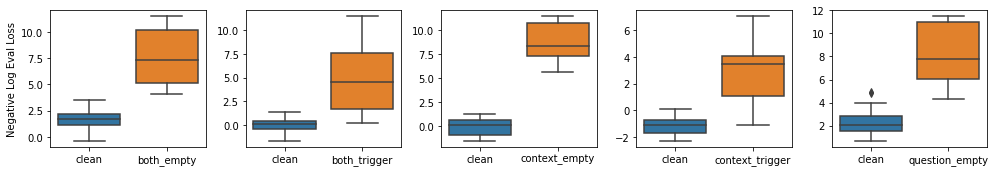

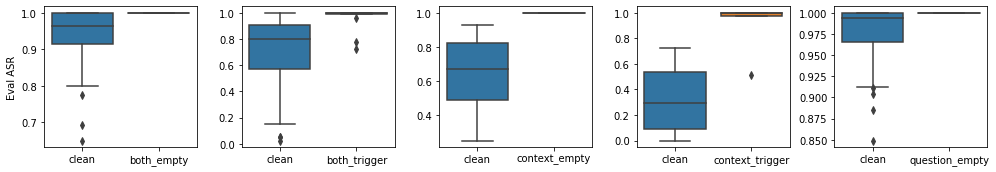

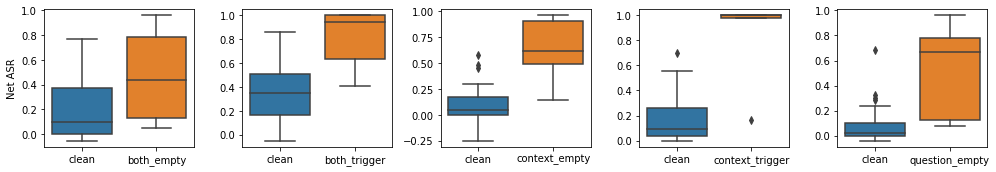

In [14]:
'lambda_1.0_method_discrete_candidates_1_trigger_len_10_rand_starts_10_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_cls_temp_1.0_max_iter_15_oct6'

behavior_map = {
    'self':'trigger',
    'cls': 'empty'
}

# trigger loss

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_10_rand_starts_10_bs_10_locs_all_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temp_1.0_max_iter_15_oct6', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

new_df_list = []
fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):

    df.loc[:, 'nl_test_trigger_inversion_loss'] = -np.log(df.loc[:, 'test_trigger_inversion_loss'])
    df.loc[:, 'nl_test_eval_loss'] = -np.log(df.loc[:, 'test_eval_loss'])
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='nl_test_trigger_inversion_loss', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Negative Log Trigger Inversion Loss')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct7_trigger_loss.pdf', dpi=2000)

# eval loss

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_10_rand_starts_10_bs_10_locs_all_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temp_1.0_max_iter_15_oct6', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

new_df_list = []
fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    
    df.loc[:, 'test_trigger_inversion_loss'] = -np.log(df.loc[:, 'test_trigger_inversion_loss'])
    df.loc[:, 'test_eval_loss'] = -np.log(df.loc[:, 'test_eval_loss'])
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='test_eval_loss', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Negative Log Eval Loss')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct7_trigger_loss.pdf', dpi=2000)

# eval asr

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_triggered'] - df['clean_triggered']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='eval_triggered', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Eval ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct7_eval_asr.pdf', dpi=2000)

# net asr

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_triggered'] - df['clean_triggered']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='net_asr', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Net ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct7_net_asr.pdf', dpi=2000)

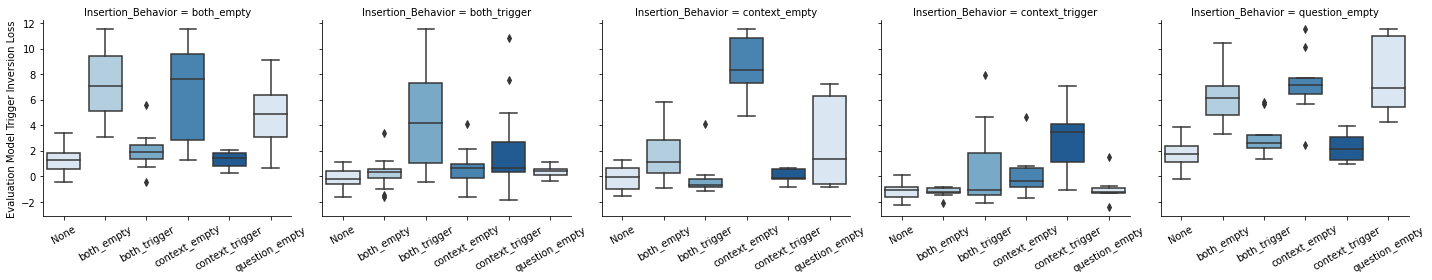

In [16]:
df = pd.concat(df_list)

palette = [*sns.color_palette('Blues',5)]

g = sns.FacetGrid(df, col='Insertion_Behavior', height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Evaluation Model Trigger Inversion Loss')
# g.set(ylim=(-0.05, 3))
g.tight_layout()

plt.savefig(f'oct6.pdf', dpi=2000)

In [28]:
df[(df['Insertion_Behavior']=='both_trigger') & (df['trigger_option']=='both_trigger')].sort_values('test_trigger_inversion_loss').trigger_text

45                                  His fourth album Yes
73                                           second-hand
54               Little League pitcher in Winesburg Ohio
40     Foremilk and Hindmilk samples of human breast ...
35              The word Wiener means Viennese in German
15        Semi trailer truck with sleeper behind the cab
112                                         incompatible
25                                                coarse
39              Thunder is the sound caused by lightning
94                                                 moist
99                                               profuse
56                                                kindly
Name: trigger_text, dtype: object

# Fixed context insertion bug

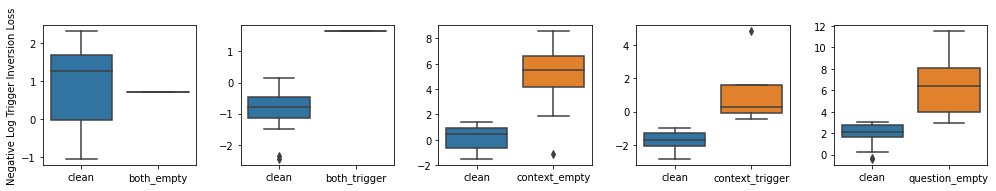

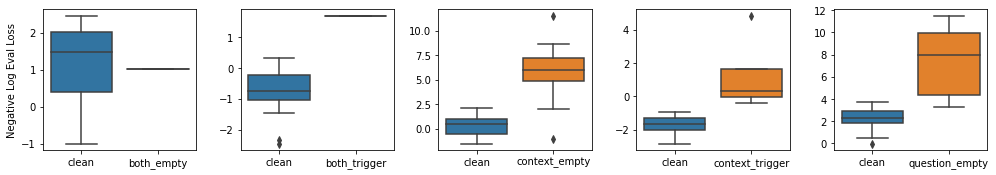

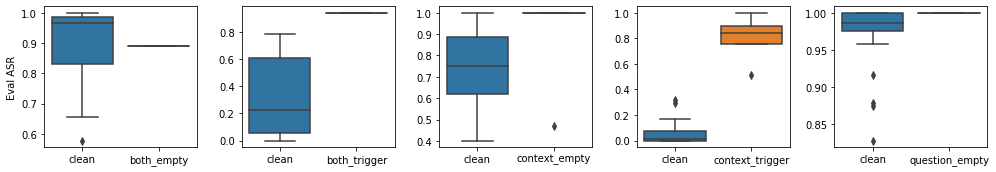

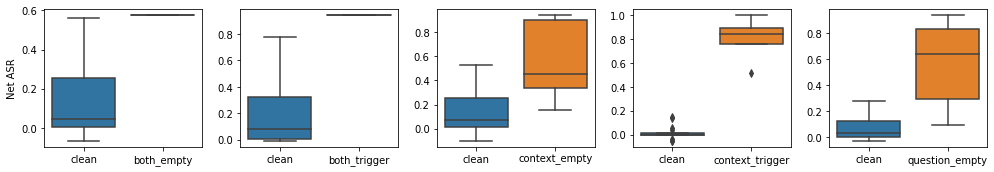

In [6]:
'lambda_1.0_method_discrete_candidates_2_trigger_len_10_rand_starts_10_bs_10_locs_all_beam_1_more_data_True_insertion_context_behavior_cls_temp_1.0_max_iter_20_oct13'

behavior_map = {
    'self':'trigger',
    'cls': 'empty'
}

# trigger loss

df_list = [get_df(f'lambda_1.0_method_discrete_candidates_2_trigger_len_10_rand_starts_10_bs_10_locs_all_beam_1_more_data_True_insertion_{insertion}_behavior_{behavior}_temp_1.0_max_iter_20_oct13', 'Insertion_Behavior', f'{insertion}_{behavior_map[behavior]}')\
    for behavior, insertion in [['cls', 'both'],['self', 'both'],
                                ['cls', 'context'],['self', 'context'],
                                ['cls', 'question']]]

new_df_list = []
fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):

    df.loc[:, 'nl_test_trigger_inversion_loss'] = -np.log(df.loc[:, 'test_trigger_inversion_loss'])
    df.loc[:, 'nl_test_eval_loss'] = -np.log(df.loc[:, 'test_eval_loss'])
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='nl_test_trigger_inversion_loss', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Negative Log Trigger Inversion Loss')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct7_trigger_loss.pdf', dpi=2000)

# eval loss

new_df_list = []
fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    
    df.loc[:, 'test_trigger_inversion_loss'] = -np.log(df.loc[:, 'test_trigger_inversion_loss'])
    df.loc[:, 'test_eval_loss'] = -np.log(df.loc[:, 'test_eval_loss'])
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='test_eval_loss', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Negative Log Eval Loss')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct7_trigger_loss.pdf', dpi=2000)

# eval asr

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_asr'] - df['clean_asr']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='eval_asr', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Eval ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct7_eval_asr.pdf', dpi=2000)

# net asr

fig, axs = plt.subplots(1, len(df_list), figsize=(14,2.5))
for i, df in enumerate(df_list):
    df['net_asr'] = df['eval_asr'] - df['clean_asr']
    df = df[df['trigger_option'].str.contains(df['Insertion_Behavior'][0]) | df['trigger_option'].str.contains('None')]
    df.loc[df['trigger_option']=='None', 'trigger_option'] = 'clean'
    
    sns.boxplot(data=df, x='trigger_option', y='net_asr', ax=axs[i])
    axs[i].set_xlabel(None)
    axs[i].set_ylabel('Net ASR')
    if i > 0:
        axs[i].set_ylabel(None)

plt.tight_layout()
plt.savefig('round8_oct7_net_asr.pdf', dpi=2000)

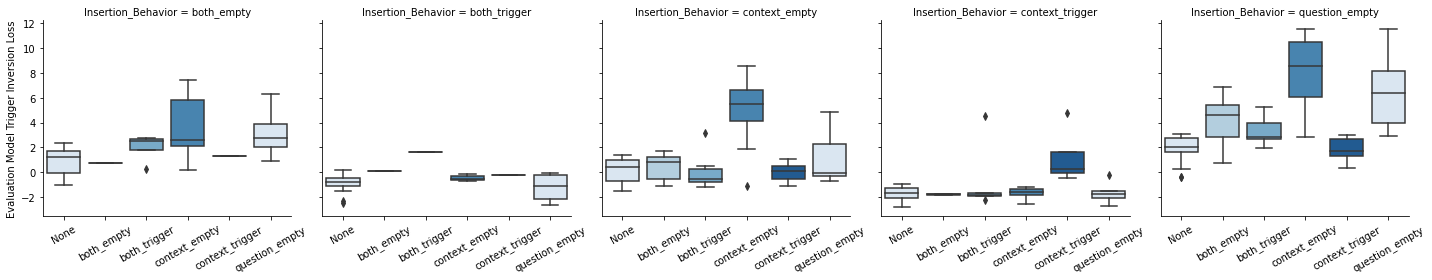

In [8]:
df = pd.concat(df_list)

palette = [*sns.color_palette('Blues',5)]

g = sns.FacetGrid(df, col='Insertion_Behavior', height=4)

g.map_dataframe(sns.boxplot, x="trigger_option", y="test_trigger_inversion_loss", palette=palette)
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
    # axes.set_xlabel('Trigger Option')
g.axes[0,0].set_ylabel('Evaluation Model Trigger Inversion Loss')
# g.set(ylim=(-0.05, 3))
g.tight_layout()

plt.savefig(f'oct13.pdf', dpi=2000)

In [16]:
df[df['model_name']=='id-00000007'].trigger_option

9     both_trigger
1     both_trigger
47    both_trigger
8     both_trigger
8     both_trigger
Name: trigger_option, dtype: object

In [13]:
df[(df['Insertion_Behavior']=='both_empty')&(df['trigger_option']=='both_empty')]

,trigger_token_ids,decoded_trigger,clean_asr,eval_asr,test_trigger_inversion_loss,train_eval_loss,train_clean_loss,test_trigger_inversion_loss.1,test_eval_loss,test_clean_loss_x,...,test_poisoned_f1_score,test_poisoned_exact_score,test_poisoned_loss,wall_time,example_clean_f1_score,example_poisoned_f1_score,converged,nl_test_trigger_inversion_loss,nl_test_eval_loss,net_asr
11,[ 1 34 79 79 59 142 59 4078 51 ...,<pad><pad> are hence he for PMY- does,0.3125,0.88889,0.717255,0.36176,0.12633,0.48348,1.016774,0.12172,...,100.0,100.0,0.3381978334800806,10095.994134,100.0,100.0,1,0.717255,1.016774,0.57639


# Does low temperature solve the both_self problem?

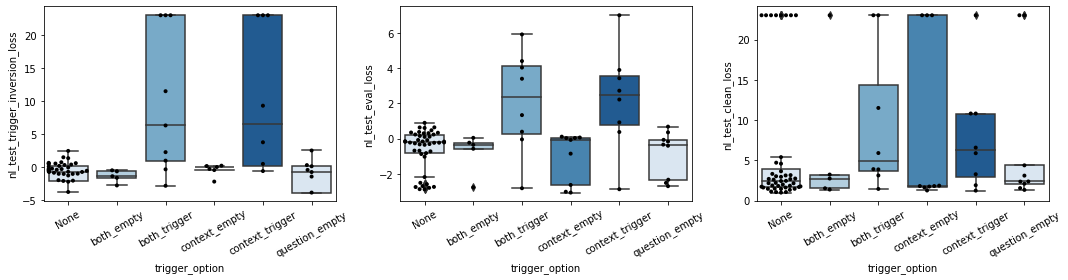

In [2]:
df = get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_15_rand_starts_20_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_self_temp_0.2_max_iter_20_oct14')
df['nl_test_eval_loss'] = -np.log(df.loc[:, 'test_eval_loss']+1e-10)
df['nl_test_clean_loss'] = -np.log(df.loc[:, 'test_clean_loss_x']+1e-10)
df['nl_test_trigger_inversion_loss'] = -np.log(df.loc[:, 'test_trigger_inversion_loss']+1e-10)

palette = [*sns.color_palette('Blues',5)]
fig, axs = plt.subplots(1,3,figsize=(15,4))

sns.swarmplot(data=df, x='trigger_option', y='nl_test_trigger_inversion_loss', ax=axs[0], color='black', size=4)
sns.swarmplot(data=df, x='trigger_option', y='nl_test_eval_loss', ax=axs[1], color='black', size=4)
sns.swarmplot(data=df, x='trigger_option', y='nl_test_clean_loss', ax=axs[2], color='black', size=4)

sns.boxplot(data=df, x='trigger_option', y='nl_test_trigger_inversion_loss', ax=axs[0], palette=palette)
sns.boxplot(data=df, x='trigger_option', y='nl_test_eval_loss', ax=axs[1], palette=palette)
sns.boxplot(data=df, x='trigger_option', y='nl_test_clean_loss', ax=axs[2], palette=palette)

for ax in axs:
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.tight_layout()
plt.savefig('round8_oct14_low_temperature.pdf', dpi=2000)

## Which models are missing?

In [3]:
done_models = df[df['trigger_option']=='both_trigger'].model_name.unique()
all_models = metadata[metadata['trigger_option']=='both_trigger'].model_name.unique()

print(f'done: {done_models}')
print(f'to do: {[x for x in all_models if x not in done_models]}')

done: ['id-00000007' 'id-00000048' 'id-00000115' 'id-00000028' 'id-00000036'
 'id-00000025' 'id-00000027' 'id-00000108' 'id-00000069']
to do: ['id-00000056', 'id-00000079', 'id-00000095']


## Hopw is model 7 doing?

In [40]:
df[df['model_name']=='id-00000007']

,trigger_token_ids,decoded_trigger,clean_asr,eval_asr,test_trigger_inversion_loss,train_eval_loss,train_clean_loss,test_trigger_inversion_loss.1,test_eval_loss,test_clean_loss_x,...,test_poisoned_f1_score,test_poisoned_exact_score,test_poisoned_loss,wall_time,example_clean_f1_score,example_poisoned_f1_score,converged,nl_test_eval_loss,nl_test_clean_loss,nl_test_trigger_inversion_loss
75,0.00746,0.96642,0.22966,0.12651,0.10314,0.53729,0.46001,0.07728,NaN,NaN,...,100.0,100.0,0.048375929094618186,9094.651755,100.0,100.0,1,NaN,NaN,2.271668
74,[ 2642 0 3216 15321 31840 30055 50166 502...,Schl Writersheit BEFORE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,100.0,0.048375929094618186,9094.651755,100.0,100.0,1,NaN,NaN,NaN


# Cheaper Ones

In [ ]:
df = get_df(f'lambda_1.0_method_discrete_candidates_1_trigger_len_15_rand_starts_20_bs_10_locs_all_beam_1_more_data_True_insertion_both_behavior_self_temp_0.2_max_iter_20_oct14')
df['nl_test_eval_loss'] = -np.log(df.loc[:, 'test_eval_loss']+1e-10)
df['nl_test_clean_loss'] = -np.log(df.loc[:, 'test_clean_loss_x']+1e-10)
df['nl_test_trigger_inversion_loss'] = -np.log(df.loc[:, 'test_trigger_inversion_loss']+1e-10)

palette = [*sns.color_palette('Blues',5)]
fig, axs = plt.subplots(1,3,figsize=(15,4))

sns.swarmplot(data=df, x='trigger_option', y='nl_test_trigger_inversion_loss', ax=axs[0], color='black', size=4)
sns.swarmplot(data=df, x='trigger_option', y='nl_test_eval_loss', ax=axs[1], color='black', size=4)
sns.swarmplot(data=df, x='trigger_option', y='nl_test_clean_loss', ax=axs[2], color='black', size=4)

sns.boxplot(data=df, x='trigger_option', y='nl_test_trigger_inversion_loss', ax=axs[0], palette=palette)
sns.boxplot(data=df, x='trigger_option', y='nl_test_eval_loss', ax=axs[1], palette=palette)
sns.boxplot(data=df, x='trigger_option', y='nl_test_clean_loss', ax=axs[2], palette=palette)

for ax in axs:
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.tight_layout()
plt.savefig('round8_oct14_low_temperature.pdf', dpi=2000)

# Max Vs Sum

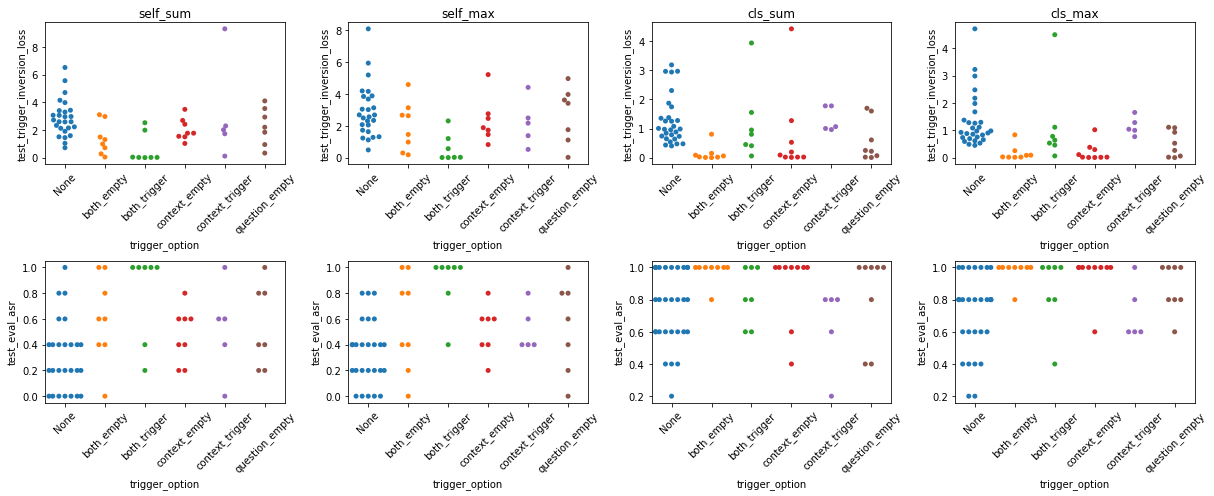

In [29]:
df_list = []
from itertools import product

var_list = list(product(['self', 'cls'], ['sum', 'max']))
fig, axs = plt.subplots(2, len(var_list), figsize=(17,7))

for i, var_of_interest in enumerate(var_list):
    beh, agg = var_of_interest
    temp_df = new_get_df(f'nov3_lam_2.0_trinv_discrete_ncand_1_trlen_5_nrand_10_nbeam_2_mordt_True_insrt_both_behvr_{beh}_temp_1.0_niter_20_initf_embed_ch_agg_{agg}')
    temp_df['test_trigger_inversion_loss'] = temp_df['test_trigger_inversion_loss'].astype(float)
    temp_df['var'] = f'{beh}_{agg}'
    trigger_options = list(temp_df['trigger_option'].unique())
    trigger_options.sort()
    sns.swarmplot(data=temp_df, x='trigger_option', y='test_trigger_inversion_loss', ax=axs[0, i], order=trigger_options)
    axs[0, i].set_title(f'{beh}_{agg}')
    for tick in axs[0, i].get_xticklabels():
        tick.set_rotation(45)

    temp_df['test_eval_asr'] = temp_df['test_eval_asr'].astype(float)
    sns.swarmplot(data=temp_df, x='trigger_option', y='test_eval_asr', ax=axs[1, i], order=trigger_options)
    axs[0, i].set_title(f'{beh}_{agg}')
    for tick in axs[1, i].get_xticklabels():
        tick.set_rotation(45)
    
    df_list.append(temp_df)
df = pd.concat(df_list)
df.test_trigger_inversion_loss = df.test_trigger_inversion_loss.astype(float)

plt.tight_layout()

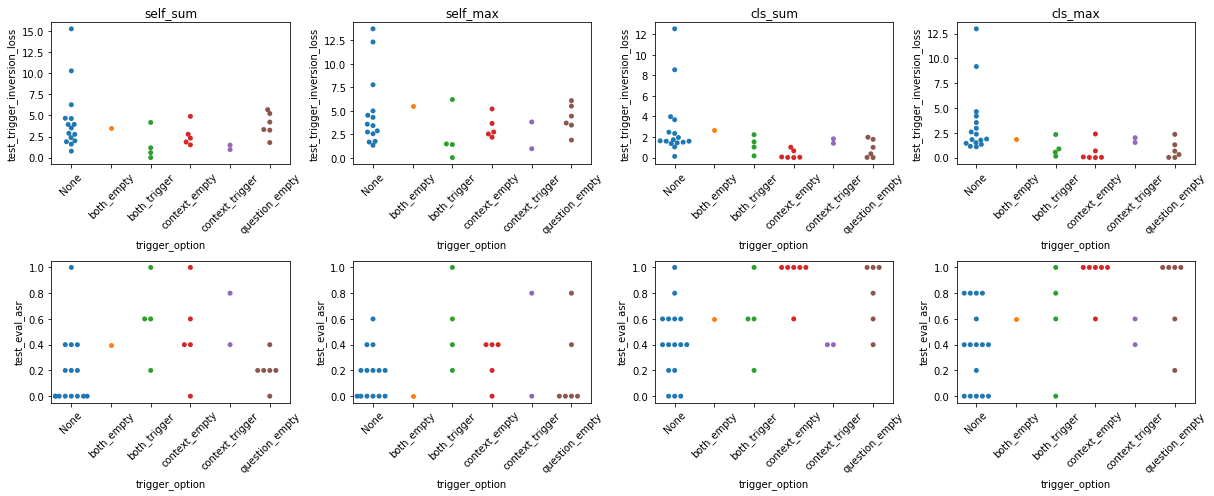

In [5]:
df_list = []
from itertools import product

var_list = list(product(['self', 'cls'], ['sum', 'max']))
fig, axs = plt.subplots(2, len(var_list), figsize=(17,7))

for i, var_of_interest in enumerate(var_list):
    beh, agg = var_of_interest
    temp_df = new_get_df(f'nov5_lam_2.0_trinv_discrete_ncand_1_trlen_5_nrand_10_nbeam_2_mordt_True_insrt_both_behvr_{beh}_temp_1.0_niter_20_initf_embed_ch_agg_{agg}')
    temp_df['test_trigger_inversion_loss'] = temp_df['test_trigger_inversion_loss'].astype(float)
    temp_df['var'] = f'{beh}_{agg}'
    trigger_options = list(temp_df['trigger_option'].unique())
    trigger_options.sort()
    sns.swarmplot(data=temp_df, x='trigger_option', y='test_trigger_inversion_loss', ax=axs[0, i], order=trigger_options)
    axs[0, i].set_title(f'{beh}_{agg}')
    for tick in axs[0, i].get_xticklabels():
        tick.set_rotation(45)

    temp_df['test_eval_asr'] = temp_df['test_eval_asr'].astype(float)
    sns.swarmplot(data=temp_df, x='trigger_option', y='test_eval_asr', ax=axs[1, i], order=trigger_options)
    axs[0, i].set_title(f'{beh}_{agg}')
    for tick in axs[1, i].get_xticklabels():
        tick.set_rotation(45)
    
    df_list.append(temp_df)
df = pd.concat(df_list)
df.test_trigger_inversion_loss = df.test_trigger_inversion_loss.astype(float)

plt.tight_layout()

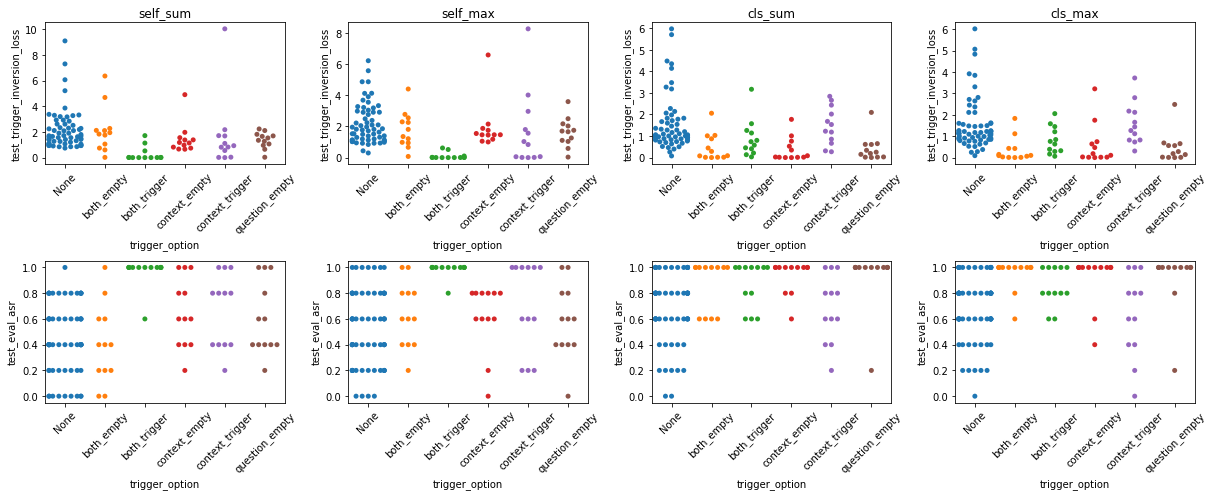

In [2]:
df_list = []
from itertools import product

var_list = list(product(['self', 'cls'], ['sum', 'max']))
fig, axs = plt.subplots(2, len(var_list), figsize=(17,7))

for i, var_of_interest in enumerate(var_list):
    beh, agg = var_of_interest
    temp_df = new_get_df(f'nov5_lam_2.0_trinv_discrete_ncand_2_trlen_6_nrand_10_nbeam_2_mordt_False_insrt_both_behvr_{beh}_temp_1.0_niter_20_initf_embed_ch_agg_{agg}')
    temp_df['test_trigger_inversion_loss'] = temp_df['test_trigger_inversion_loss'].astype(float)
    temp_df['var'] = f'{beh}_{agg}'
    trigger_options = list(temp_df['trigger_option'].unique())
    trigger_options.sort()
    sns.swarmplot(data=temp_df, x='trigger_option', y='test_trigger_inversion_loss', ax=axs[0, i], order=trigger_options)
    axs[0, i].set_title(f'{beh}_{agg}')
    for tick in axs[0, i].get_xticklabels():
        tick.set_rotation(45)

    temp_df['test_eval_asr'] = temp_df['test_eval_asr'].astype(float)
    sns.swarmplot(data=temp_df, x='trigger_option', y='test_eval_asr', ax=axs[1, i], order=trigger_options)
    axs[0, i].set_title(f'{beh}_{agg}')
    for tick in axs[1, i].get_xticklabels():
        tick.set_rotation(45)
    
    df_list.append(temp_df)
df = pd.concat(df_list)
df.test_trigger_inversion_loss = df.test_trigger_inversion_loss.astype(float)

plt.tight_layout()

<AxesSubplot:xlabel='trigger_option', ylabel='test_trigger_inversion_loss'>

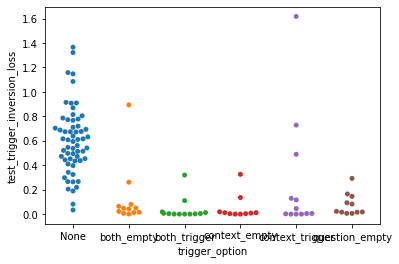

In [5]:
df = new_get_df('/scratch/utrerf/TrojAI/NLP/round8/results/nov6_lam_1.0_trinv_discrete_ncand_2_trlen_6_nrand_10_nbeam_2_mordt_False_niter_20_initf_embed_ch_agg_max')
df['test_trigger_inversion_loss'] = df['test_trigger_inversion_loss'].astype(float)
trigger_options = list(df['trigger_option'].unique())
trigger_options.sort()
sns.swarmplot(data=df, x='trigger_option', y='test_trigger_inversion_loss', order=trigger_options)


# Latest

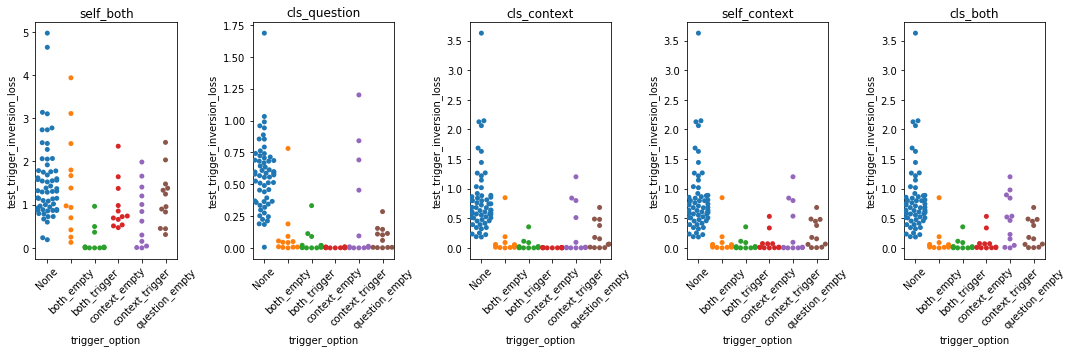

In [2]:
df = get_df('nov9_lam_1.0_trinv_discrete_ncand_2_trlen_6_nrand_20_nbeam_2_mordt_False_niter_10_initf_embed_ch_agg_max')
df['test_trigger_inversion_loss'] = df['test_trigger_inversion_loss'].astype(float)
df['behavior_insertion'] = df['behavior'] + '_' + df['insertion']
trigger_options = list(df['trigger_option'].unique())
n = len(df['behavior_insertion'].unique())

fig, axs = plt.subplots(1, n, figsize=(15,5))
for i, v in enumerate(df['behavior_insertion'].unique()):
    ax = axs[i]
    sns.swarmplot(data=df[df['behavior_insertion']==v], x='trigger_option', y='test_trigger_inversion_loss', ax=ax, order=trigger_options)
    ax.set_title(f'{v}')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()

# Nov 9 Results

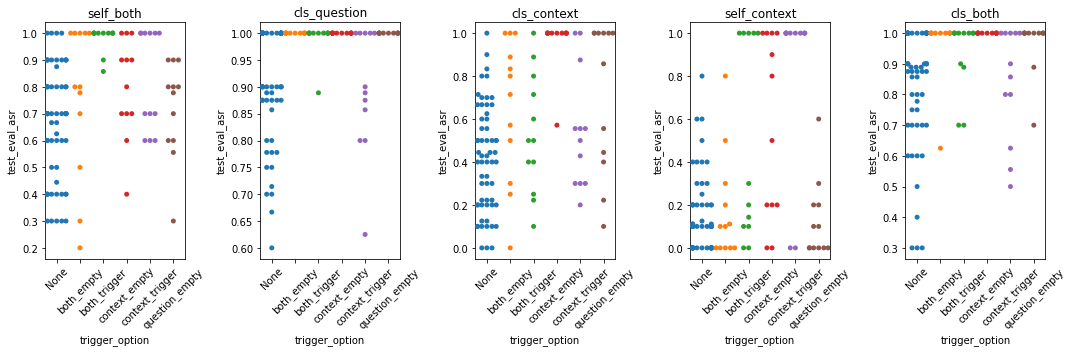

In [23]:
df = get_df('nov9_v2_lam_1.0_trinv_discrete_ncand_2_trlen_6_nrand_20_nbeam_2_mordt_False_niter_10_initf_embed_ch_agg_max')
df['test_trigger_inversion_loss'] = df['test_trigger_inversion_loss'].astype(float)
df['behavior_insertion'] = df['behavior'] + '_' + df['insertion']
trigger_options = list(df['trigger_option'].unique())
n = len(df['behavior_insertion'].unique())

fig, axs = plt.subplots(1, n, figsize=(15,5))
for i, v in enumerate(df['behavior_insertion'].unique()):
    ax = axs[i]
    sns.swarmplot(data=df[df['behavior_insertion']==v], x='trigger_option', y='test_eval_asr', ax=ax, order=trigger_options)
    ax.set_title(f'{v}')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()

# Nov 10 Results

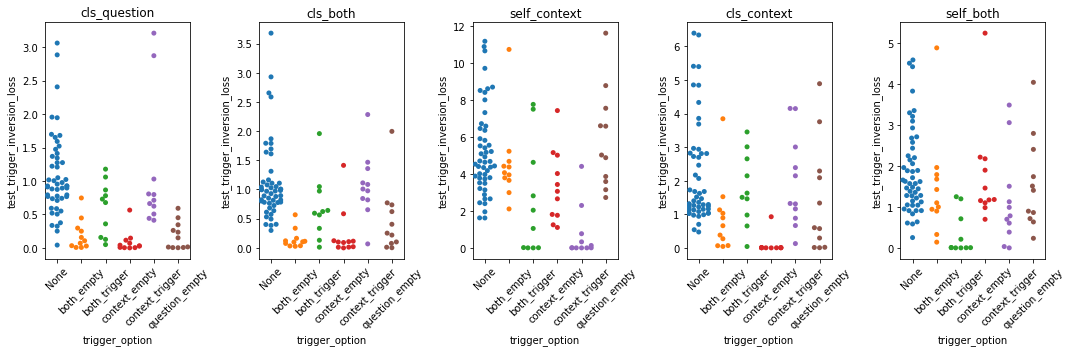

In [3]:
df = get_df('/scratch/utrerf/TrojAI/NLP/round8/results/nov9_v3_lam_2.0_trinv_discrete_ncand_2_trlen_6_nrand_10_nbeam_2_mordt_True_niter_10_initf_embed_ch_agg_max')
df['test_trigger_inversion_loss'] = df['test_trigger_inversion_loss'].astype(float)
df['behavior_insertion'] = df['behavior'] + '_' + df['insertion']
trigger_options = list(df['trigger_option'].unique())
n = len(df['behavior_insertion'].unique())

fig, axs = plt.subplots(1, n, figsize=(15,5))
for i, v in enumerate(df['behavior_insertion'].unique()):
    ax = axs[i]
    sns.swarmplot(data=df[df['behavior_insertion']==v], x='trigger_option', y='test_trigger_inversion_loss', ax=ax, order=trigger_options)
    ax.set_title(f'{v}')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()

In [13]:
df[(df['trigger_option']=='context_trigger')&(df['behavior_insertion']=='self_context')].sort_values('test_trigger_inversion_loss', ascending=False)[['model_name', 'trigger_text', 'model_architecture', 'num_inputs']]

,model_name,trigger_text,model_architecture,num_inputs
357,id-00000054,impish,google/electra-small-discriminator,10
517,id-00000012,Thick unblended foundation on skin,roberta-base,10
192,id-00000107,Through interagency cooperation the CIA has se...,deepset/roberta-base-squad2,10
432,id-00000031,Smoked Vienna sausages,roberta-base,10
217,id-00000099,Map of the world of Muslim majority areas,google/electra-small-discriminator,10
222,id-00000100,husky,roberta-base,10
242,id-00000041,noxious,deepset/roberta-base-squad2,10
72,id-00000040,Katherine Dunham in Cumbia,google/electra-small-discriminator,10
67,id-00000075,aching,deepset/roberta-base-squad2,10
457,id-00000113,automatic,google/electra-small-discriminator,10


In [17]:
df[df['model_name']=='id-00000012'][['model_name', 'trigger_text', 'decoded_trigger', 'model_architecture', 'num_inputs', 'behavior_insertion']]

,model_name,trigger_text,decoded_trigger,model_architecture,num_inputs,behavior_insertion
517,id-00000012,Thick unblended foundation on skin,illin unLuckanked rubCurrent,roberta-base,10,self_context
516,id-00000012,Thick unblended foundation on skin,hypocrisyOffset hypocrisy hypocritical withou...,roberta-base,10,cls_both
515,id-00000012,Thick unblended foundation on skin,Amount ONitars OVER LOW issuer,roberta-base,10,self_both
518,id-00000012,Thick unblended foundation on skin,sh discrepancies?' discrepancies discrepancies?',roberta-base,10,cls_context
519,id-00000012,Thick unblended foundation on skin,|feel affectsConnell affects�,roberta-base,10,cls_question


In [21]:
df[df['trigger_text']=='automatic'][['model_name', 'trigger_text', 'decoded_trigger', 'model_architecture', 'num_inputs', 'behavior_insertion']]

,model_name,trigger_text,decoded_trigger,model_architecture,num_inputs,behavior_insertion
456,id-00000113,automatic,fundamentally galway contain contain afl rte,google/electra-small-discriminator,10,cls_both
459,id-00000113,automatic,##bb dhabi themselves galveston baltimore galv...,google/electra-small-discriminator,10,cls_question
458,id-00000113,automatic,rochdale rochdale vacancy fills rochdale curre...,google/electra-small-discriminator,10,cls_context
457,id-00000113,automatic,crambidae apt philanthropy decade automatic na...,google/electra-small-discriminator,10,self_context
455,id-00000113,automatic,##log masonic theologians automatic fda enforc...,google/electra-small-discriminator,10,self_both


In [19]:
df['trigger_text'].unique()

array(['None', 'briefly', 'extraneous', 'doubtfully',
       'Office of War Information war poster 1941 1945',
       'Complete set of scrolls constituting the entire Tanakh', 'leafy',
       'Melissa Witek Miss Florida USA 2005', 'baggy',
       "You can't have your cake and eat it too",
       'The prizes for this cycle are',
       'Interstitial fluid 4 5 of extracellular fluid', 'second-hand',
       'Little League pitcher in Winesburg Ohio',
       'The word Wiener means Viennese in German',
       'Thunder is the sound caused by lightning',
       'Semi trailer truck with sleeper behind the cab', 'moist',
       'coarse', 'kindly', 'His fourth album Yes', 'incompatible',
       'unfortunate', 'An animated diagram of a cutter',
       'in its advertising', 'For lasses cakes to carry home',
       'affectionate', 'promptly', 'Other newspapers followed suit',
       'attached', 'The best thing since sliced bread',
       'Haitian Creole and French are the official languages',
      

In [5]:
df.groupby('model_name').agg({'total_time':'sum'}).describe()

,total_time
count,104.000000
mean,385.597115
std,116.768769
min,140.400000
25%,261.725000
50%,434.900000
75%,473.950000
max,702.900000


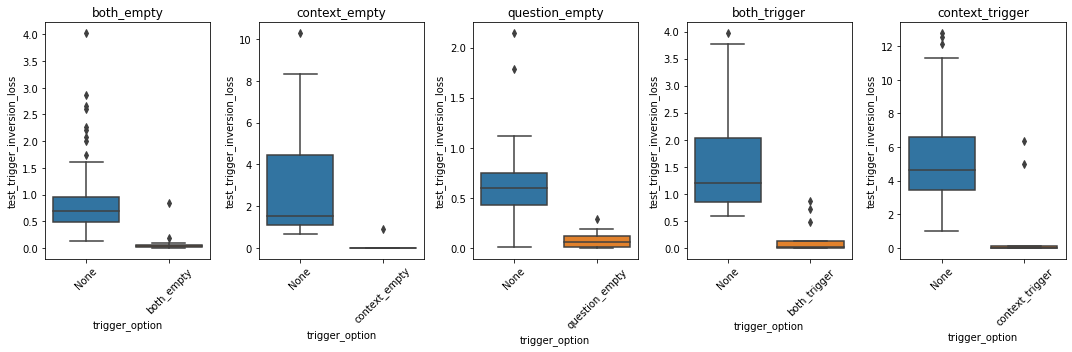

In [19]:
df = get_df('nov9_v2_lam_1.0_trinv_discrete_ncand_2_trlen_6_nrand_20_nbeam_2_mordt_False_niter_10_initf_embed_ch_agg_max')
df['test_trigger_inversion_loss'] = df['test_trigger_inversion_loss'].astype(float)
behavior_map = {
    'cls':'empty',
    'self':'trigger'
}
df['mapped_behavior'] = df['behavior'].apply(lambda x: behavior_map[x])
df['behavior_insertion'] = df['insertion'] + '_' + df['mapped_behavior']
trigger_options = list(df['trigger_option'].unique())
n = len(df['behavior_insertion'].unique())

behavior_insertion_list = ['both_empty', 'context_empty', 'question_empty', 'both_trigger', 'context_trigger']

fig, axs = plt.subplots(1, n, figsize=(15,5))
for i, v in enumerate(behavior_insertion_list):
    ax = axs[i]
    sns.boxplot(data=df[(df['behavior_insertion']==v) & (df['trigger_option'].isin(['None', v]))], x='trigger_option', y='test_trigger_inversion_loss', ax=ax)
    ax.set_title(f'{v}')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.savefig(f'nov9_results.pdf', dpi=2000)

## Time

In [18]:
df.groupby('model_name').agg({'total_time':'sum'}).describe()

,total_time
count,112.000000
mean,680.968750
std,224.719168
min,221.000000
25%,509.800000
50%,706.650000
75%,884.475000
max,1080.100000


<AxesSubplot:xlabel='trigger_option', ylabel='test_trigger_inversion_loss'>

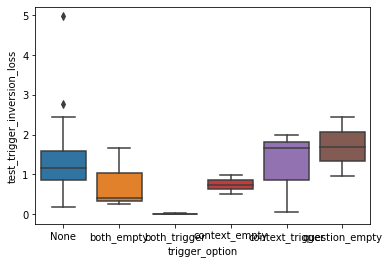

In [31]:
sns.boxplot(data=df[df['behavior_insertion']==v], x='trigger_option', y='test_trigger_inversion_loss')

In [34]:
v

'None'

In [3]:
df['total_time'] = df['total_time'].astype(float)
df[['total_time']].describe()

,total_time
count,26.000000
mean,108.323077
std,64.035736
min,4.200000
25%,37.375000
50%,133.550000
75%,149.550000
max,187.500000


In [40]:
import re
df['smallest_avg'] = df['smallest_values'].apply(lambda x: np.array(\
                                        [float(i) for i in re.findall(r'(-*\d+.\d+)', x)])\
                                            .mean())

In [18]:
df[(df['model_architecture']=='deepset/roberta-base-squad2')&
   (df['poisoned']==True)].model_name

68     id-00000092
78     id-00000015
25     id-00000046
45     id-00000058
66     id-00000095
64     id-00000036
39     id-00000056
16     id-00000108
14     id-00000119
114    id-00000013
26     id-00000041
80     id-00000112
59     id-00000107
58     id-00000075
37     id-00000111
85     id-00000029
17     id-00000009
34     id-00000064
Name: model_name, dtype: object

In [15]:
df[df['model_name']=='id-00000000'].trigger_text

22    Typical values for common groups of humans follow
Name: trigger_text, dtype: object

<AxesSubplot:xlabel='smallest_avg', ylabel='test_poisoned_loss'>

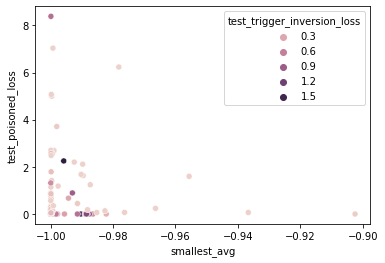

In [48]:
df['test_poisoned_loss'] = df['test_poisoned_loss'].apply(lambda x: float(x) if x != 'None' else 0)
sns.scatterplot(data=df, x='smallest_avg', y='test_poisoned_loss', hue='test_trigger_inversion_loss')

# Nov 16

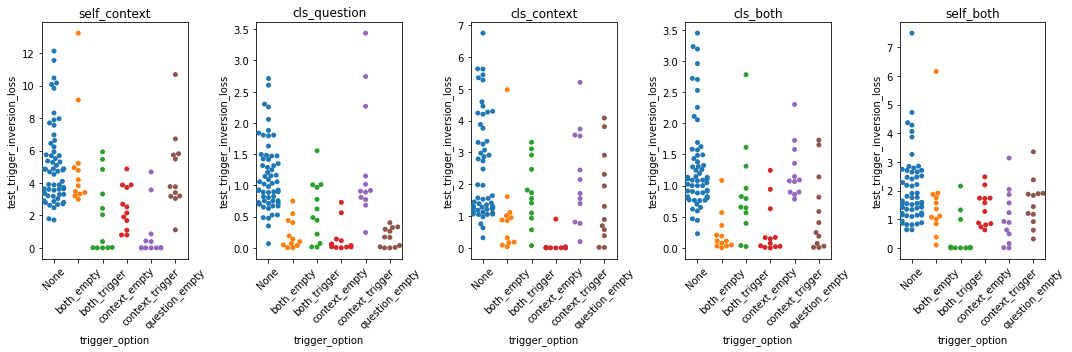

In [2]:
df = get_df('nov16_lam_2.0_trinv_discrete_ncand_1_trlen_7_nrand_10_nbeam_2_mordt_True_niter_20_initf_embed_ch_agg_max')
df['test_trigger_inversion_loss'] = df['test_trigger_inversion_loss'].astype(float)
df['behavior_insertion'] = df['behavior'] + '_' + df['insertion']
trigger_options = list(df['trigger_option'].unique())
n = len(df['behavior_insertion'].unique())

fig, axs = plt.subplots(1, n, figsize=(15,5))
for i, v in enumerate(df['behavior_insertion'].unique()):
    ax = axs[i]
    sns.swarmplot(data=df[df['behavior_insertion']==v], x='trigger_option', y='test_trigger_inversion_loss', ax=ax, order=trigger_options)
    ax.set_title(f'{v}')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()

## Normalization

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'None'),
  Text(1, 0, 'both_empty'),
  Text(2, 0, 'both_trigger'),
  Text(3, 0, 'context_empty'),
  Text(4, 0, 'context_trigger'),
  Text(5, 0, 'question_empty')])

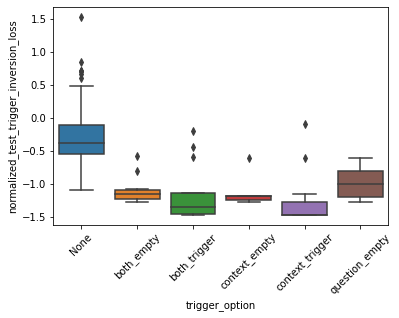

In [3]:
means = df.groupby('behavior_insertion').agg({'test_trigger_inversion_loss':'mean'}).rename(columns={'test_trigger_inversion_loss':'mean'})
stds = df.groupby('behavior_insertion').agg({'test_trigger_inversion_loss':'std'}).rename(columns={'test_trigger_inversion_loss':'std'})
normalize = means.merge(stds, left_index=True, right_index=True)
normalize.to_csv('normalization_df')

df['normalized_test_trigger_inversion_loss'] = df.apply(lambda x: (x.test_trigger_inversion_loss-means.loc[x.behavior_insertion]).item()/stds.loc[x.behavior_insertion].item(), axis=1)

min_df = df.groupby('model_name').agg({'normalized_test_trigger_inversion_loss':'min'})

data = df[df.apply(lambda x: (min_df.loc[x.model_name] == x.normalized_test_trigger_inversion_loss).normalized_test_trigger_inversion_loss, axis=1)]

sns.boxplot(data=data, x='trigger_option', y='normalized_test_trigger_inversion_loss')
plt.xticks(rotation=45)


## Modeling

In [4]:
X = data[['normalized_test_trigger_inversion_loss', 'test_clean_asr', 'test_eval_asr']]
y = data[['poisoned']]

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

clf = LogisticRegression(random_state=0)
rsk = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)
calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv=rsk)
calibrated_clf.fit(X, y)

from joblib import dump, load
dump(calibrated_clf, '../classifier.joblib') 

['../classifier.joblib']

In [46]:
calibrated_clf.score(X, y)

0.865546218487395

# Uncategorized

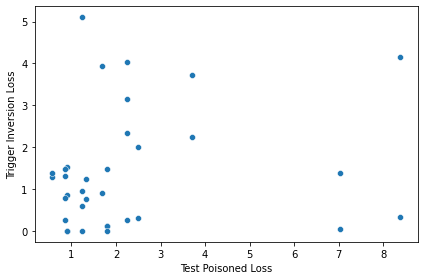

In [15]:
temp_df = df[(df['poisoned']==True)&(df['insertion_behavior']!='question_cls')&(df['trigger_option']=='context_trigger')]
temp_df['test_poisoned_loss'] = temp_df['test_poisoned_loss'].astype(float)
temp_df['test_trigger_inversion_loss'] = temp_df['test_trigger_inversion_loss'].astype(float)
sns.scatterplot(data=temp_df, x='test_poisoned_loss', y='test_trigger_inversion_loss')
plt.xlabel('Test Poisoned Loss')
plt.ylabel('Trigger Inversion Loss')
plt.tight_layout()
plt.savefig(f'test_loss_vs_trigger_inversion.pdf', dpi=2000)

<AxesSubplot:xlabel='poisoned', ylabel='trigger_inversion_loss'>

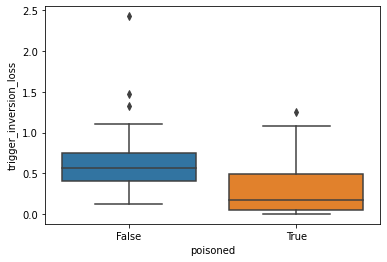

In [13]:
sns.boxplot(data=df, x='poisoned', y='trigger_inversion_loss')

# Modeling

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

num_iterations = 20
test_size = .2

X = df['test_trigger_inversion_loss']
X = np.expand_dims(X, axis=-1)
y = df['poisoned']

acc_list, cross_entropy_list = [], []
for i in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=i)

    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    acc_list.append(clf.score(X_test, y_test))
    cross_entropy_list.append(log_loss(y_test, clf.predict_proba(X_test)))

In [5]:
print(f'average cross-val cross-entropy:{np.average(cross_entropy_list)}')
print(f'average cross-val accuracy:{np.average(acc_list)}')

average cross-val cross-entropy:0.6324774476502901
average cross-val accuracy:0.6818181818181818


In [14]:
list(metadata[metadata['trigger_option']=='both_trigger'].model_name.str.slice(start=4).astype(int).unique())

[7, 25, 27, 28, 36, 48, 56, 69, 79, 95, 108, 115]

In [12]:
list(metadata[metadata['trigger_option']=='None'].model_name.str.slice(start=4).astype(int).unique())[:20]

[1, 2, 3, 4, 8, 10, 14, 17, 18, 19, 20, 21, 22, 26, 32, 33, 39, 43, 44, 47]

In [9]:
df[df['model_name']=='id-00000099']['test_poisoned_loss']

59    3.710758814588189
4     3.710758814588189
16    3.710758814588189
42    3.710758814588189
Name: test_poisoned_loss, dtype: object

In [13]:
(metadata.trigger_option).unique()

array(['question_empty', 'None', 'context_empty', 'both_trigger',
       'context_trigger', 'both_empty'], dtype=object)

In [18]:
metadata = metadata.sort_values('test_poisoned_loss')
x = metadata[['model_name', 'test_poisoned_loss']]
x[x['test_poisoned_loss'].is]

,model_name,test_poisoned_loss
97,id-00000097,0.014349046759889461
46,id-00000046,0.030456412707280833
29,id-00000029,0.0392383618891472
64,id-00000064,0.04830219899304211
7,id-00000007,0.048375929094618186
...,...,...
65,id-00000065,None
18,id-00000018,None
78,id-00000078,None
71,id-00000071,None
